# 1. Importing the data

In [42]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

file_path = '../../_data/institutos1.csv'

# Load the CSV data into a DataFrame
institutos_df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify the data is loaded correctly
print(institutos_df.head())

   cod_mod  ltimoden_metaatencion  cuentadeid_postulante_procesoadm  \
0   207597                    307                               481   
1   207613                    240                               502   
2   239970                    537                              1047   
3   262311                    423                               526   
4   273979                    425                               544   

   sumaden_flagingresante  sumaden_flagmatriculado     ratio    ratio1  dif  \
0                     302                      301  0.980456  1.566775   -6   
1                     204                      204  0.850000  2.091667  -36   
2                     484                      476  0.886406  1.949721  -61   
3                     353                      349  0.825059  1.243499  -74   
4                     411                      405  0.952941  1.280000  -20   

   dif1   nlat_ie  ...  population_ccpp  altitude  Dblock1km  Dblock2km  \
0   174 -13.52107  ... 

In [43]:
encabezados = institutos_df.columns.tolist()

# Print the list of column headers
print(encabezados)

['cod_mod', 'ltimoden_metaatencion', 'cuentadeid_postulante_procesoadm', 'sumaden_flagingresante', 'sumaden_flagmatriculado', 'ratio', 'ratio1', 'dif', 'dif1', 'nlat_ie', 'nlong_ie', 'population_ccpp', 'altitude', 'Dblock1km', 'Dblock2km', 'Dblock3km', 'Dblock5km', 'Dblock10km', 'Dblock20km', 'Dblock30km', '_merge']


# 2. generate a Choropleth map of the total institutes' vacancies by the department

In [44]:
import geopandas as gpd
import pandas as pd
inst_geo = gpd.GeoDataFrame(
    institutos_df,
    geometry=gpd.points_from_xy(institutos_df.nlong_ie, institutos_df.nlat_ie),
    crs='EPSG:4326'
)
# Now 'inst_geo' is a GeoDataFrame with the institutes' data including a geometry column with point data


In [45]:
# Read the shapefile for department boundaries
dept_boundaries_path = '../../_data/INEI_LIMITE_DEPARTAMENTAL/INEI_LIMITE_DEPARTAMENTAL.shp'
dept_boundaries = gpd.read_file(dept_boundaries_path)

In [46]:
# Intersect institutes with department boundaries
institutes_with_departments = gpd.overlay(inst_geo, dept_boundaries, how='intersection')

In [47]:
encabezados_columnas = institutes_with_departments.columns.tolist()

# Print the list of column headers
print(encabezados_columnas)

['cod_mod', 'ltimoden_metaatencion', 'cuentadeid_postulante_procesoadm', 'sumaden_flagingresante', 'sumaden_flagmatriculado', 'ratio', 'ratio1', 'dif', 'dif1', 'nlat_ie', 'nlong_ie', 'population_ccpp', 'altitude', 'Dblock1km', 'Dblock2km', 'Dblock3km', 'Dblock5km', 'Dblock10km', 'Dblock20km', 'Dblock30km', '_merge', 'OBJECTID_1', 'OBJECTID', 'CCDD', 'NOMBDEP', 'CAPITAL', 'Shape_STAr', 'Shape_STLe', 'ORIG_FID', 'Shape_Leng', 'Shape_Area', 'CORREO', 'CONTACTO', 'WHATSAPP', 'geometry']


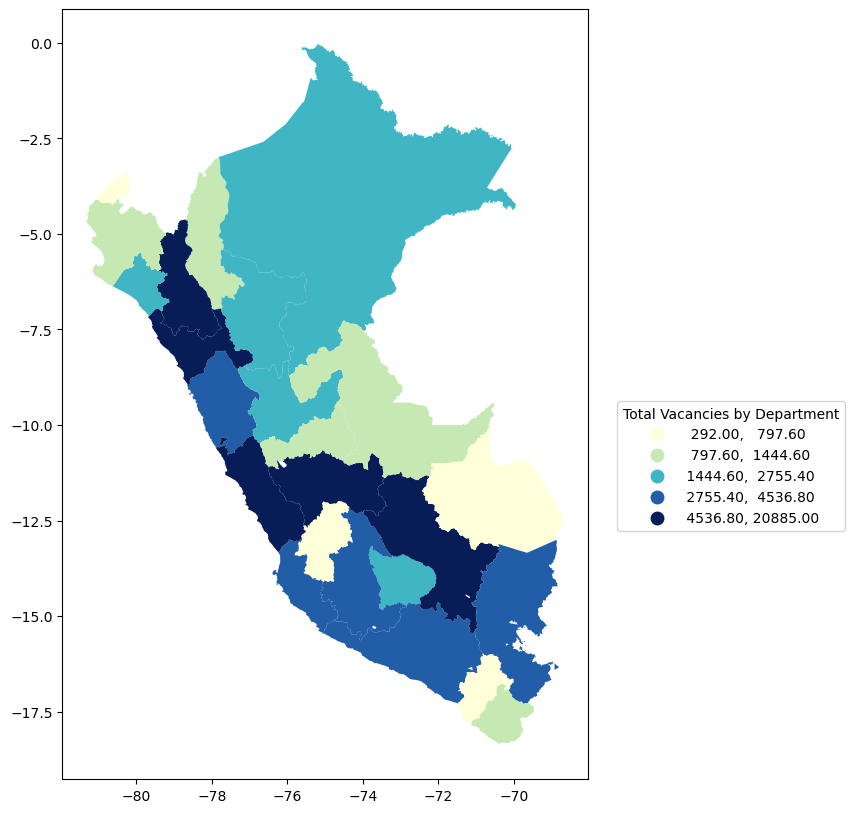

In [48]:
# group data by department name ('NOMBDEP') and aggregate specific columns to calculate the total 
#number of vacancies, applicants, entrants, and enrolled students for each department
grouped = institutes_with_departments.groupby('NOMBDEP').agg({
    'ltimoden_metaatencion': 'sum',  # total vacancies
    'cuentadeid_postulante_procesoadm': 'sum',  # Total applicants
    'sumaden_flagingresante': 'sum',  # Total entrants
    'sumaden_flagmatriculado': 'sum'  # Total enrolled students
}).reset_index()

# Merge the aggregated data with the departmental boundaries
dept_vacancies = dept_boundaries.merge(vacancies_by_department, on='NOMBDEP')

# Create the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
dept_vacancies.plot(
    column='ltimoden_metaatencion',
    cmap='YlGnBu',
    legend=True,
    scheme='quantiles',
    ax=ax
)

# Manually configure the legend
leg = ax.get_legend()
leg.set_title('Total Vacancies by Department')
leg.set_bbox_to_anchor((1.5, 0.5))

plt.show()

# 3. Make an interactive map of markes using visual_html function and show total vacancies, applicants, entrants, and enrolled information in a table popup

In [49]:
!pip install folium
import folium

In [50]:
# Create a base map
mapa1 = folium.Map(location=[-9.19, -75.0152], zoom_start=6)  # Coordenadas centrales de Perú

# Add markers to the map.
for idx, row in institutes_with_departments.iterrows():
    # Crear el contenido HTML para la ventana emergente
    html_content = folium.Html(f"""
        <table>
            <tr><th>Total Vacancies:</th><td>{row['ltimoden_metaatencion']}</td></tr>
            <tr><th>Total Applicants:</th><td>{row['cuentadeid_postulante_procesoadm']}</td></tr>
            <tr><th>Total Entrants:</th><td>{row['sumaden_flagingresante']}</td></tr>
            <tr><th>Total Enrolled:</th><td>{row['sumaden_flagmatriculado']}</td></tr>
        </table>
    """, script=True)

    # Create the popup window with HTML content
    popup = folium.Popup(html_content, max_width=2650)

    # Add the marker with the popup window to the map
    folium.Marker(
        [row['nlat_ie'], row['nlong_ie']],
        popup=popup,
        icon=folium.Icon(icon='university', prefix='fa')  # Utiliza el ícono de universidad de FontAwesome
    ).add_to(mapa1)

# Display the map
mapa1

# 3

# 4

# 5

# 6